In [ ]:
# Some examples are based on the liboptpy library, where basic methods are implemented from scratch
!pip install git+https://github.com/amkatrutsa/liboptpy

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import ipywidgets as ipywidg
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
from tqdm import tqdm

<IPython.core.display.Javascript object>


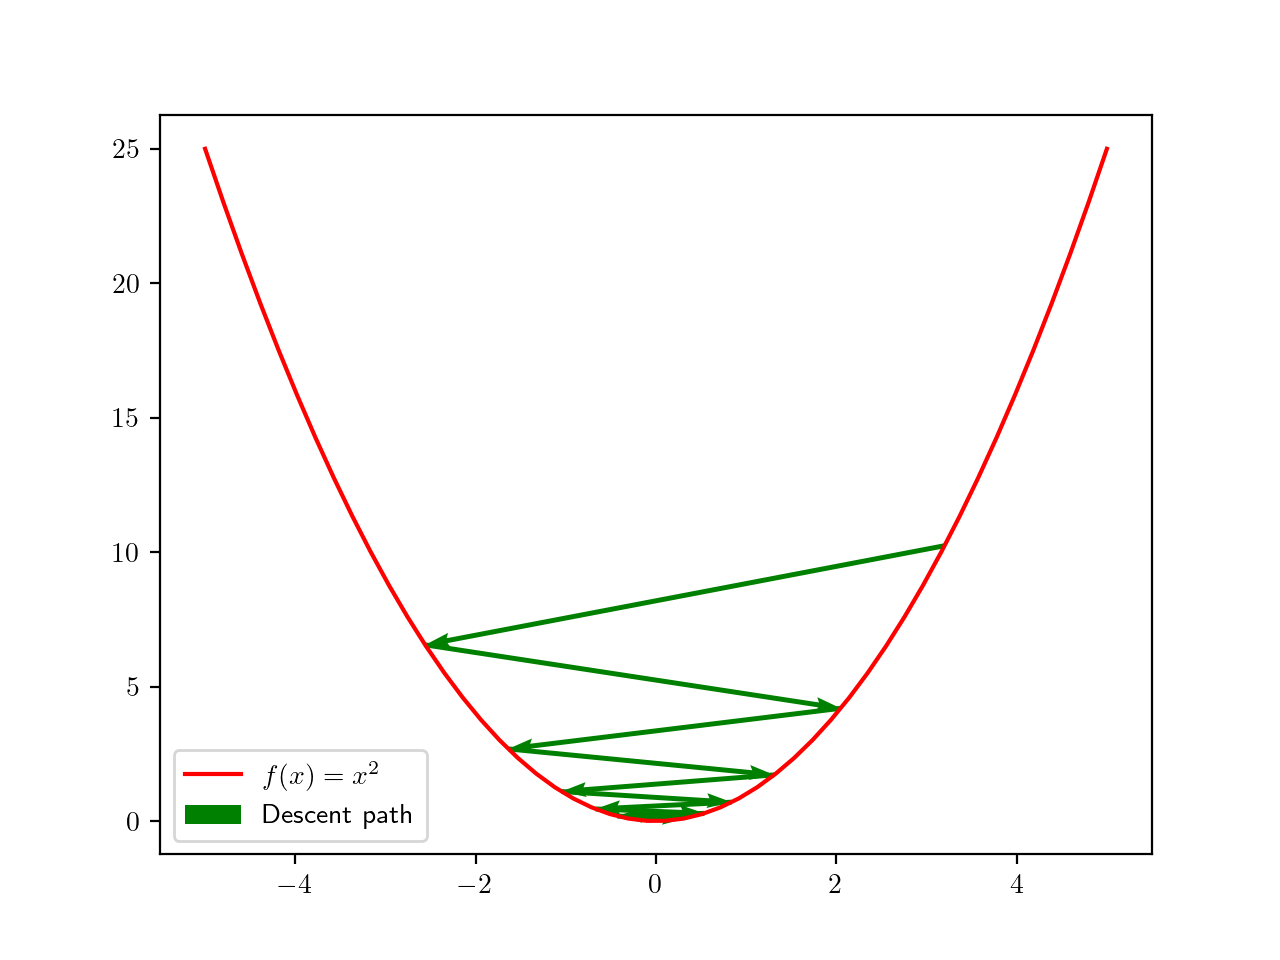

interactive(children=(FloatSlider(value=1.5, description='Initial point', max=4.0, min=-4.0), FloatSlider(valu…

In [2]:
f = lambda x: np.power(x, 2)
gradf = lambda x: 2 * x

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)



def update(x0, step):
    gd = methods.fo.GradientDescent(f, gradf, ss.ConstantStepSize(step))
    _ = gd.solve(np.array([x0]), max_iter=10)
    x_hist = gd.get_convergence()
    x = np.linspace(-5, 5)
    ax.clear()
    ax.plot(x, f(x), color="r", label="$f(x) = x^2$")
    y_hist = np.array([f(x) for x in x_hist])
    x_hist = np.array(x_hist)
    plt.quiver(x_hist[:-1], y_hist[:-1], x_hist[1:]-x_hist[:-1], y_hist[1:]-y_hist[:-1], 
               scale_units='xy', angles='xy', scale=1, width=0.005, color="green", label="Descent path")
    ax.legend()
    fig.canvas.draw()

step_slider = ipywidg.FloatSlider(value=0.8, min=0, max=1.2, step=0.1, description="Step")
x0_slider = ipywidg.FloatSlider(value=1.5, min=-4, max=4, step=0.1, description="Initial point")
_ = ipywidg.interact(update, x0=x0_slider, step=step_slider)

### Зависимость от обусловленности матрицы $f''(x)$
Рассмотрим задачу 
$$
\min f(x),
$$ 
где
$$ f(x) = x^{\top}Ax, \; A = \begin{bmatrix} 1 & 0\\ 0 & \gamma \end{bmatrix} $$

$$
f'(x) = 2Ax
$$

In [3]:
def my_f(x, A):
    return 0.5 * x.dot(A.dot(x))

def my_gradf(x, A):
    return A.dot(x)

<IPython.core.display.Javascript object>


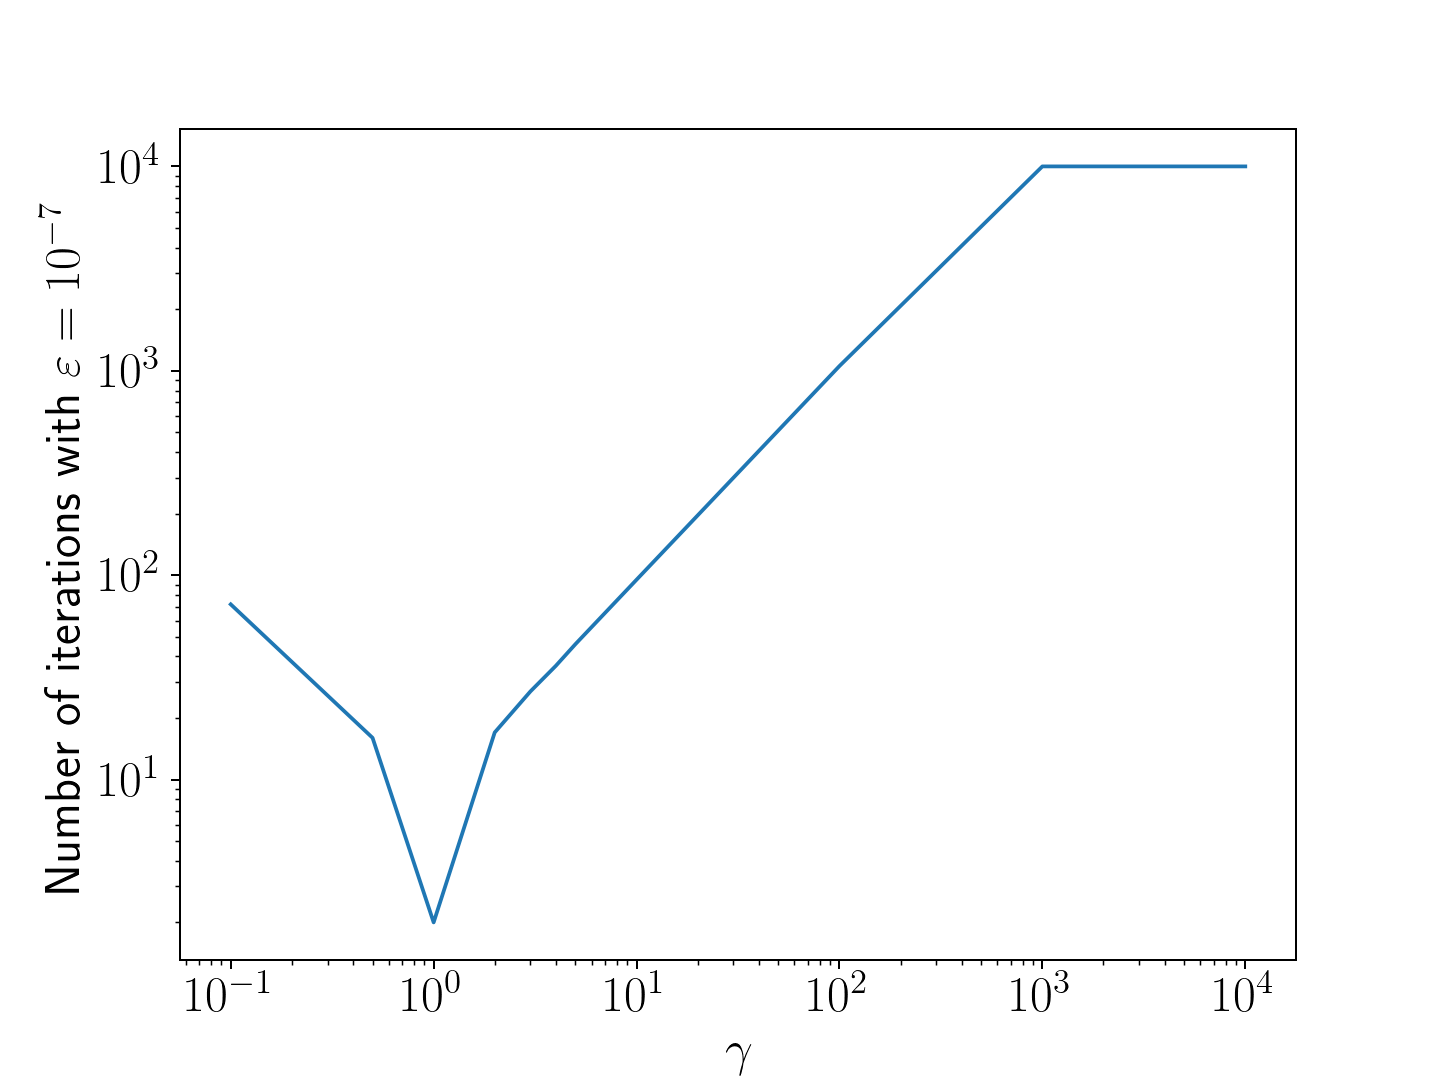

Text(0, 0.5, 'Number of iterations with $\\varepsilon = 10^{-7}$')

In [5]:
plt.rc("text", usetex=True)

gammas = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 20, 50, 100, 1000, 5000, 10000]
# gammas = [1]
num_iter_converg = []
for g in gammas:
    A = np.array([[1, 0], 
                  [0, g]], dtype=np.float64)
    f = lambda x: my_f(x, A)
    gradf = lambda x: my_gradf(x, A)
#     x0 = np.random.rand(A.shape[0])
#     x0 = np.sort(x0)
#     x0 = x0[::-1]
    x0 = np.array([g, 1], dtype=np.float64)
#     print x0[1] / x0[0]
    gd = methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A))
    x = gd.solve(x0, tol=1e-7, max_iter=10000)
    num_iter_converg.append(len(gd.get_convergence()))

plt.figure(figsize=(8, 6))
plt.loglog(gammas, num_iter_converg)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r"$\gamma$", fontsize=20)
plt.ylabel(r"Number of iterations with $\varepsilon = 10^{-7}$", fontsize=20)

In [6]:
n = 100
A = np.random.randn(n, n)
A = A.T @ A + np.eye(n)
x_true = np.random.randn(n)
b = A @ x_true

In [8]:
def f(x):
    return 0.5 * x @ A @ x - b @ x 

def grad(x):
    return A @ x - b 

In [10]:
def gd(grad, x0, num_iter, tol, alpha):
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(num_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break

        x = x - alpha * g
        conv.append(x.copy())
    return x, conv

In [11]:
x0 = np.random.randn(n)
numiter = 10000

In [12]:
np.linalg.norm(A, 2)

372.5341561321089

In [13]:
eigs = np.linalg.eigvalsh(A)
L = max(eigs)
print(np.linalg.cond(A))
mu = min(eigs)
print(mu)

372.40369103023744
1.000350332461802


In [14]:
x_gd, conv_gd = gd(grad, x0, numiter, 1e-6, 1. / L)

<IPython.core.display.Javascript object>


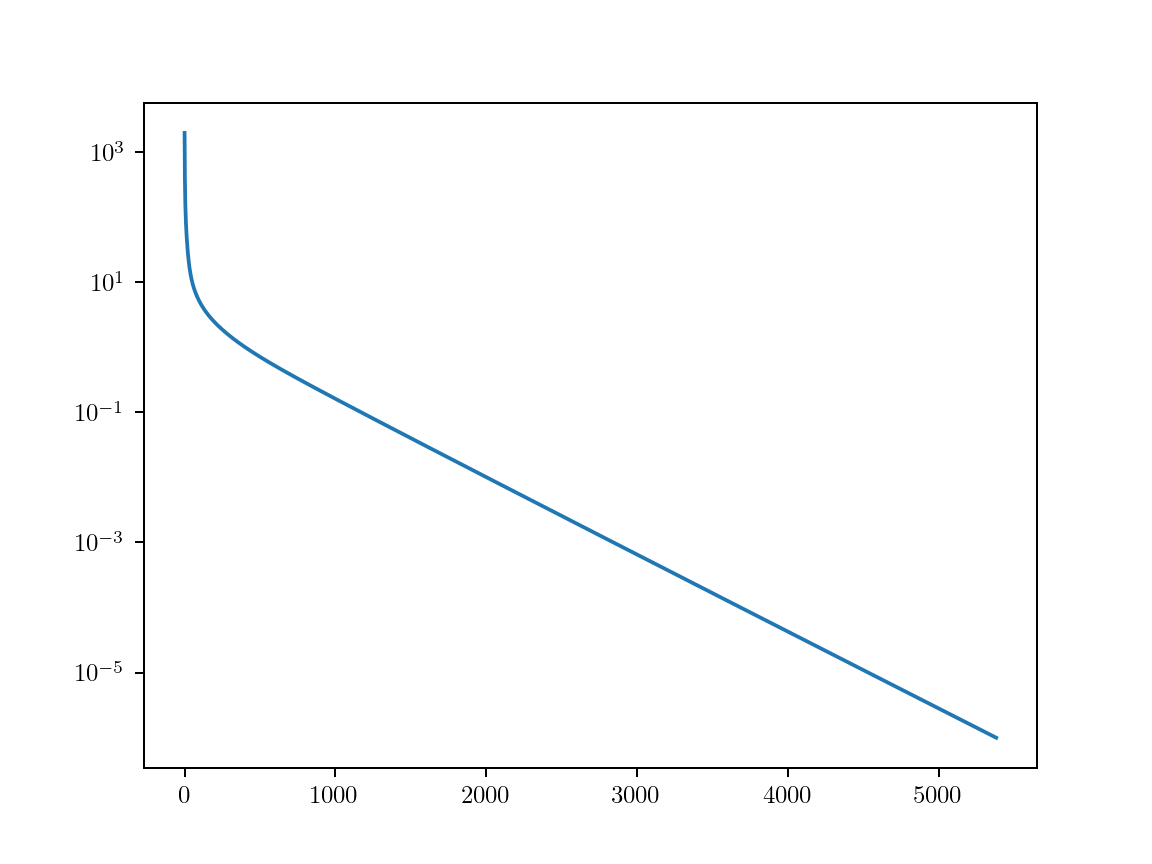

In [15]:
plt.plot([np.linalg.norm(grad(x)) for x in conv_gd])
plt.yscale("log")

<IPython.core.display.Javascript object>


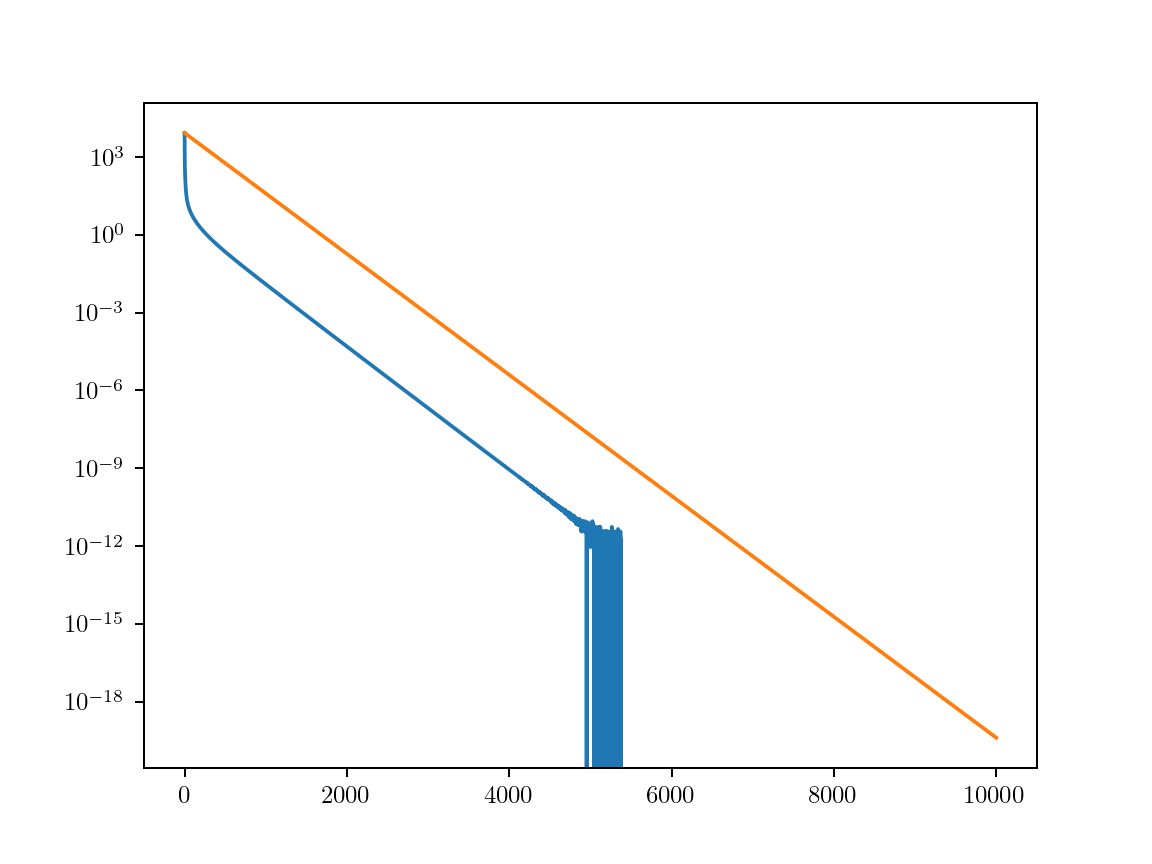

In [17]:
plt.plot([f(x) - f(x_true) for x in conv_gd])
kappa = L / mu
plt.plot([((kappa - 1) / (kappa + 1))**k * (f(x0) - f(x_true)) for k in range(numiter)])
plt.yscale("log")

In [20]:
def armijo(f, x, grad, h, beta, rho, alpha0):
    alpha = alpha0
    fval = f(x)
    gh = grad @ h
    while True: 
        if f(x + alpha * h) < fval + beta * alpha * gh:
            break
        else:
            alpha *= rho
        if alpha < 1e-16:
            break
    return alpha

In [21]:
def gd_adaptive(f, grad, x0, num_iter, tol, beta, rho):
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(num_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        alpha = armijo(f, x, g, -g, beta, rho, 1.)
        if alpha < 1e-16:
            break
        x = x - alpha * g
        conv.append(x.copy())
    return x, conv

In [22]:
x_gda, conv_gda = gd_adaptive(f, grad, x0, numiter, 1e-6, 0.01, 0.8)

<IPython.core.display.Javascript object>


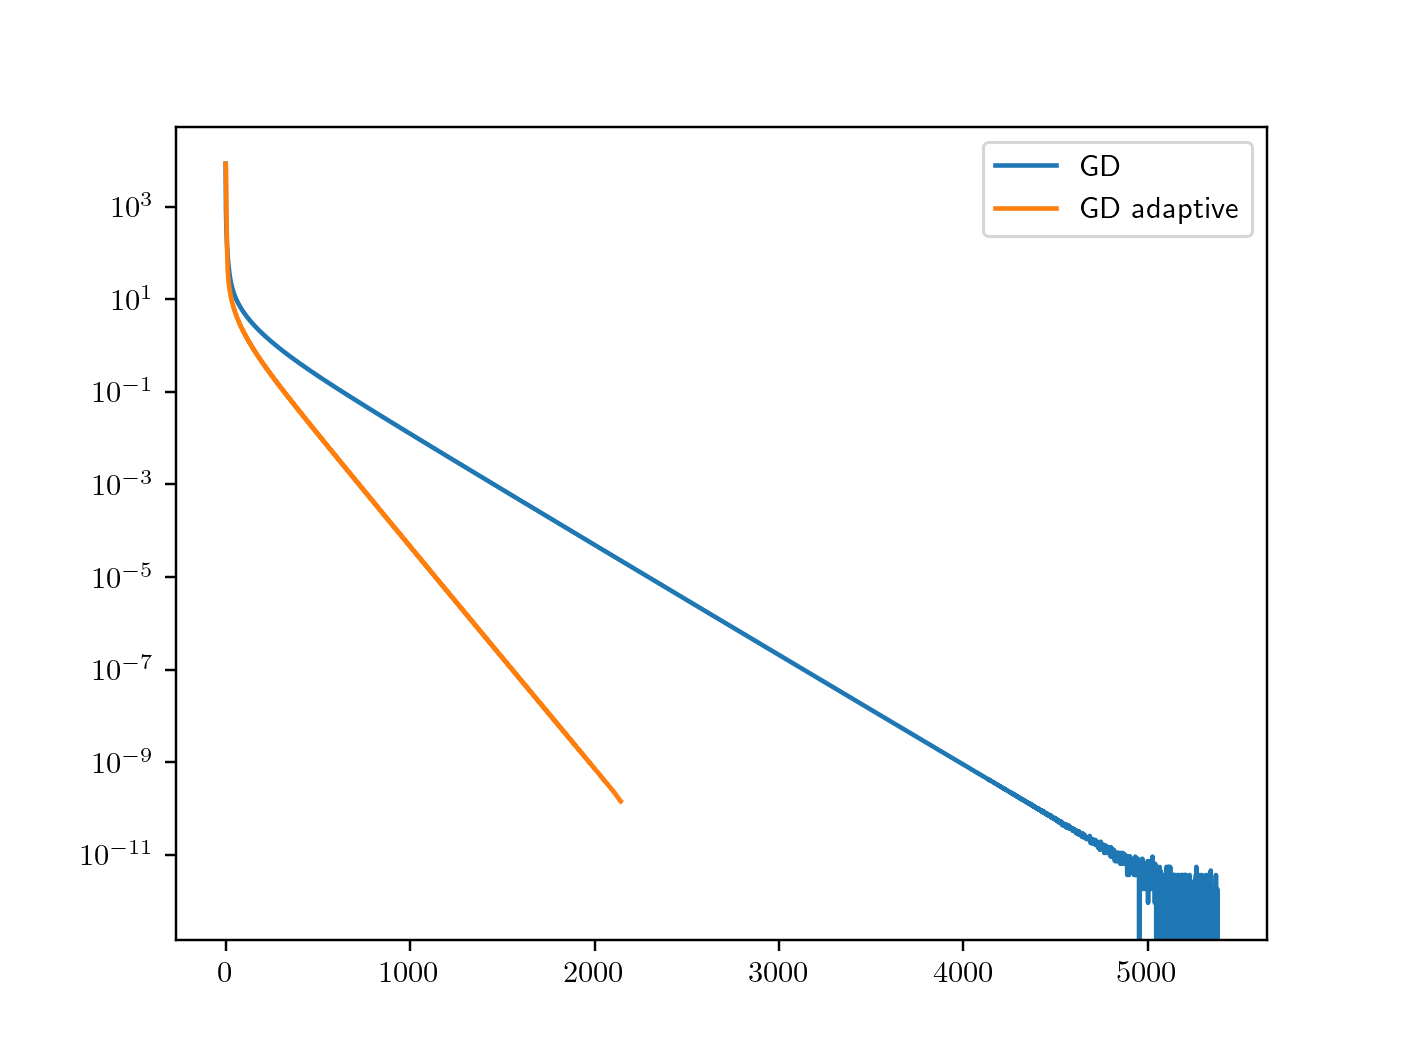

In [24]:
plt.plot([f(x) - f(x_true) for x in conv_gd], label="GD")
plt.plot([f(x) - f(x_true) for x in conv_gda], label="GD adaptive")
plt.legend()
plt.yscale("log")

In [25]:
%timeit gd_adaptive(f, grad, x0, numiter, 1e-6, 0.1, 0.5)
%timeit gd(grad, x0, numiter, 1e-6, 1. / L)

357 ms ± 98.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
83.1 ms ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


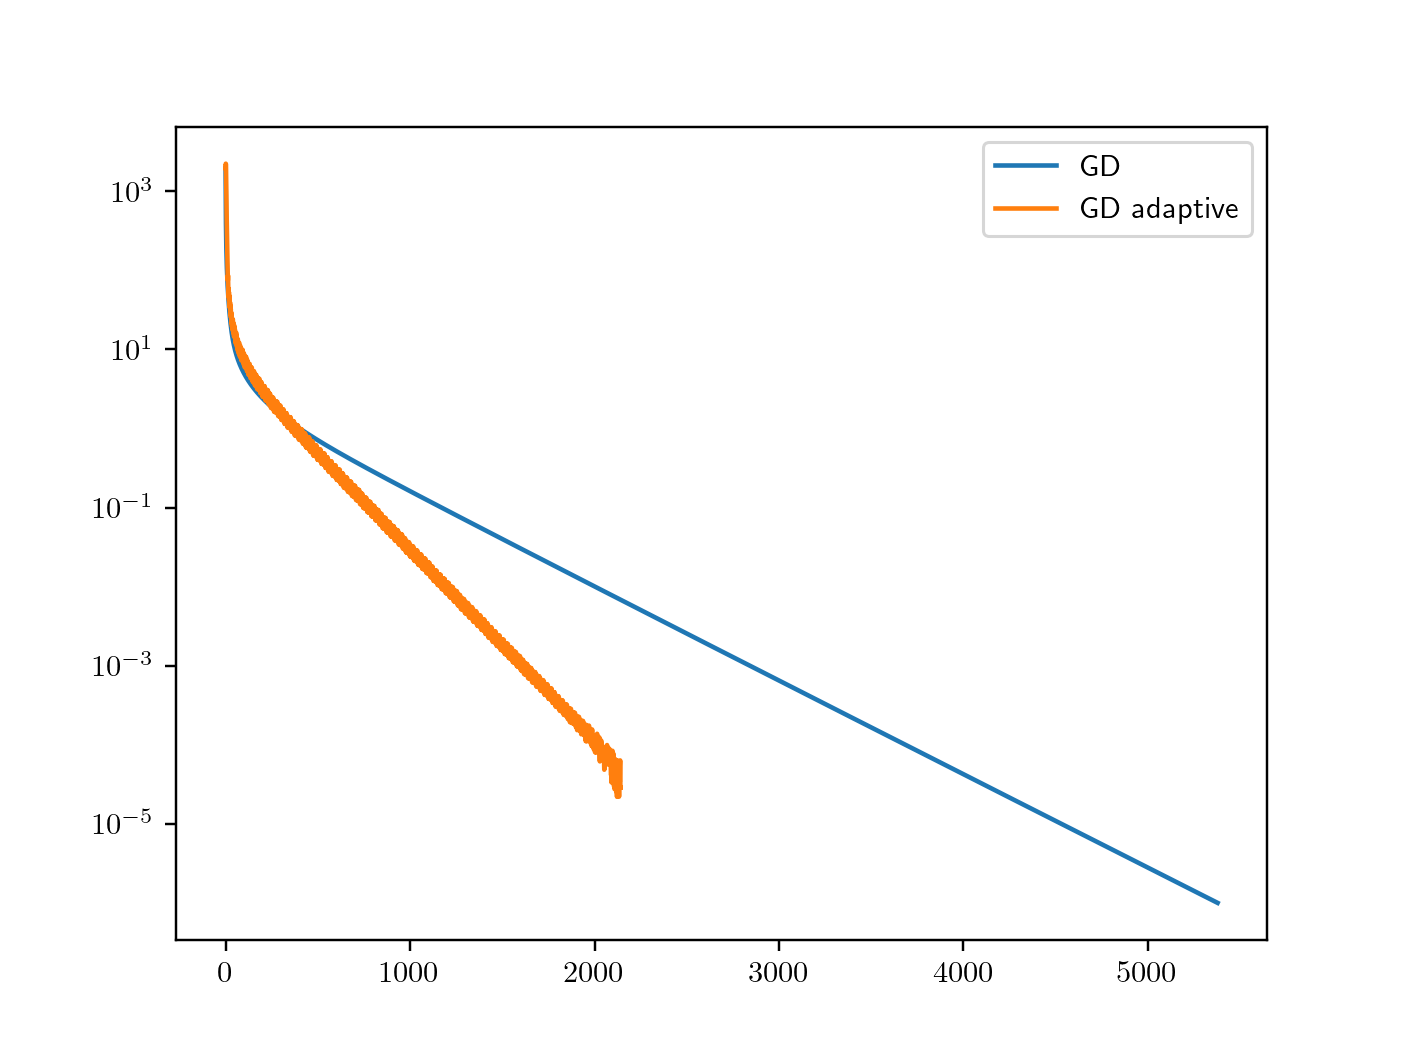

In [26]:
plt.plot([np.linalg.norm(grad(x))  for x in conv_gd], label="GD")
plt.plot([np.linalg.norm(grad(x))  for x in conv_gda], label="GD adaptive")
plt.legend()
plt.yscale("log")